## 卷积神经网络相关程序


#### 1.引言：运用卷积核操作进行图像处理案例

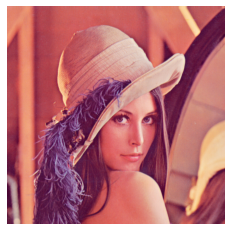

In [1]:
# 引入PIL读取图片，分离RGB三通道
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 读取图片
img = Image.open('lena.png')
plt.axis("off")
plt.imshow(img)

灰度图像：
- 0表示黑
- 255表示白
- 其他数字表示不同的灰度。
- 转换公式：L = R * 299/1000 + G * 587/1000+ B * 114/1000。

(-0.5, 511.5, 511.5, -0.5)

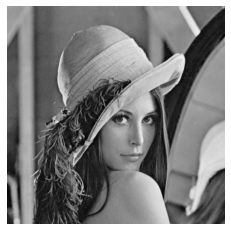

In [2]:
gray = img.convert('L')
plt.figure()
plt.imshow(gray, cmap='gray')
plt.axis('off')

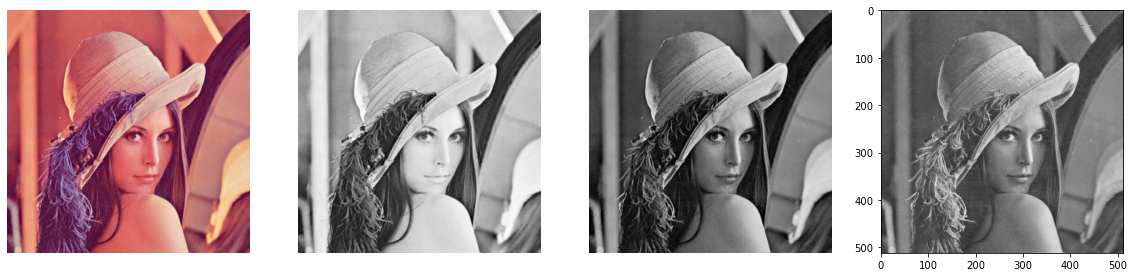

In [26]:
r, g, b = img.split()

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.axis("off")
plt.imshow(img)

plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(r,cmap='gray')

plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(g,cmap='gray')

plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(b,cmap='gray')

In [21]:
import numpy as np
# 定义卷积函数
def convolution(k, data):
    n,m = data.shape
    img_new = []
    for i in range(n-2):
        line = []
        for j in range(m-2):
            a = data[i:i+3,j:j+3]
            line.append(np.sum(np.multiply(k, a)))
        img_new.append(line)
    return np.array(img_new)

# 对某一通道进行卷积
def transform(channel,k):
    data=np.array(channel)
    n,m=data.shape
    img_new=convolution(k,data)
    return img_new

(512, 512, 3)


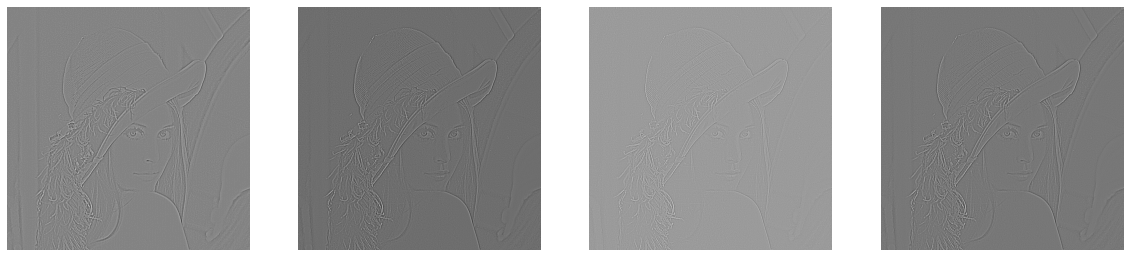

In [36]:
img_array=np.array(img)
print(img_array.shape)

# 定义卷积核（提取边缘特征）
k = np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
])

rt=transform(r,k)
gt=transform(g,k)
bt=transform(b,k)

#卷积结果可视化
plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(rt, cmap='gray')

plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(gt, cmap='gray')

plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(bt, cmap='gray')

plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(rt+gt+bt,cmap='gray')

#### 2.卷积神经网络和传统神经网络的参数对比
通过实验可以发现一个*4层的卷积神经网络*参数量比一个*3层的全连接神经网络*还要少很多参数，而且这个例子中***卷积神经网络最后两层也是全连接层***。

In [6]:
import tensorflow as tf
# 查看参数数量
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

In [7]:
#导入包
from keras import layers
from keras import models

#构建卷积神经网络模型
model=models.Sequential()
# 32个卷积核 所以参数量是（3*3+1）*32，同时32个卷积核，stride为1且不padding情况下，会变成26*26*32的厚度
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))

model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))

#在卷积神经网络模型上添加分类器
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 dense (Dense)               (None, 11, 11, 256)       16640     
                                                                 
 dense_1 (Dense)             (None, 11, 11, 10)        2570      
                                                                 
Total params: 38,026
Trainable params: 38,026
Non-trainable params: 0
____________________________________________________

In [8]:
network=models.Sequential()#模型选择sequential
network.add(layers.Dense(256,activation='relu',input_shape=(28*28,)))#256个隐藏节点，激活函数采用relu函数，输入784像素
network.add(layers.Dense(256,activation='relu'))#256个隐藏节点，激活函数采用relu函数，输入784像素
network.add(layers.Dense(10,activation='softmax'))#十个类别，分类函数采用softmax

#编译步骤
network.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


#### 3.VGG16
##### 3.1 用opencv处理大小不一的数据图片，统一将图片变为224*224

In [ ]:
import cv2 as cv
import os
import numpy as np


#把cut_img裁成和norm_img形状相同的图片
def cut_photo(H, W, cut_img):  # 设置输出固定形状的图片
    H, W = H, W
    h, w, *c = cut_img.shape
    size = 1 if [] == c else 3  # c是空c=1,其它c=3
    if H / h < W / w:
        img2 = cv.resize(cut_img, (int(w * (H / h)), H), interpolation=cv.INTER_LINEAR)
        _, w, *_ = img2.shape
        left = int((W - w) / 2)
        right = int(np.ceil((W - w) / 2))
        top, bottom = 0, 0
        img2_cut = cv.copyMakeBorder(img2, top, bottom, left, right, cv.BORDER_CONSTANT, value=np.zeros(size))
    else:
        img2 = cv.resize(cut_img, (W, int(h * (W / w))), interpolation=cv.INTER_LINEAR)
        h, _, *_ = img2.shape
        top = int((H - h) / 2)  # 距各边界宽度
        bottom = int(np.ceil((H - h) / 2))
        left, right = 0, 0
        img2_cut = cv.copyMakeBorder(img2, top, bottom, left, right, cv.BORDER_CONSTANT, value=np.zeros(size))
    return img2_cut


def read_photo(H, W, img_path, save_path):
    if not os.path.exists(save_path):  # 如果path存在，返回True；如果path不存在，返回False。
        os.mkdir(save_path)  # 创建目录
    for i, name in enumerate(os.listdir(img_path)):
        filename = os.path.join(img_path, name)
        img = cv.imdecode(np.fromfile(filename, np.uint8), -1)
        cut_img = cut_photo(H, W, img)
        cv.imwrite(os.path.join(save_path, "{}.jpg".format(str(i))), cut_img)


img_path = r"D:/Download/BaiduNetdiskDownload/flower_photos/tulips"
save_path = r"./cut_img/tulips"
read_photo(224, 224, img_path, save_path)

#### 3.2 将各个照片按照一定比例分为训练集和测试集两个文件夹

In [8]:
# 将一个文件夹下图片按比例分在三个文件夹下
import os
import random
import shutil
from shutil import copy2
datadir_normal = "cut_img/tulips"

all_data = os.listdir(datadir_normal)#（图片文件夹）
num_all_data = len(all_data)
print( "num_all_data: " + str(num_all_data) )
index_list = list(range(num_all_data))
#print(index_list)
random.shuffle(index_list)
num = 0

trainDir = "./cut_img/train/tulips"#（将训练集放在这个文件夹下）
if not os.path.exists(trainDir):
    os.mkdir(trainDir)
        
testDir = './cut_img/test/tulips'#（将测试集放在这个文件夹下）        
if not os.path.exists(testDir):
    os.mkdir(testDir)
        
for i in index_list:
    fileName = os.path.join(datadir_normal, all_data[i])
    if num < num_all_data*0.8:
        copy2(fileName, trainDir)
    else:
        copy2(fileName, testDir)
    num += 1

num_all_data: 799


#### 3.3 VGG 16

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))
print(x_train.shape, ' ', y_train.shape,type(x_train))
print(x_test.shape, ' ', y_test.shape,type(x_test))


(60000, 28, 28, 1)   (60000,) <class 'numpy.ndarray'>
(10000, 28, 28, 1)   (10000,) <class 'numpy.ndarray'>


In [ ]:
x_shape  = x_train.shape
cnn = keras.Sequential(
[
    # Block One
    # 传入（224,224,3）作为输入，filter:卷积器个数
    layers.Conv2D(input_shape=((x_shape[1], x_shape[2], x_shape[3])),
                 filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])
cnn.summary()